# Convert kagle dataset to COCO format

## Simple structure of COCO dataset:
```
{
 "info": info,
 "licenses": [license],
 "categories": [category],
 "images": [image],
 "annotations": [annotation]
}
```

First, let's import some basic libraries. I also import pycocotools that help work with the COCO RLE (Run Length Encoding) format.

In [18]:
from PIL import Image
import numpy as np
import pycocotools.mask as mask_utils
import matplotlib.pyplot as plt
import json
import csv
import cv2
import os
import sys
maxInt = sys.maxsize

while True:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.

    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)

### Load information about images that contains in `train` folder.

In [17]:
ITER = 0 # which subfolder we want to use to construct json with information about images

In [10]:
img_names = os.listdir("./{}".format(ITER))
img_name_to_id = {}
coco_dataset = {}
images = []
for i in range(len(img_names)):
    img_name_to_id[img_names[i]] = i+1
    info = {}
    img = Image.open('./{}/{}'.format(ITER,img_names[i]))
    width, height = img.size
    info['id'] = i+1
    info['file_name'] = img_names[i]
    info['width'] = width
    info['height'] = height
    images.append(info)
    
coco_dataset['images'] = images

### Fill information about annotations. 


Here I fill information about type of clothes, bounding box and area of this clothes.

Detectron2 doesn't support COCO RLE format. So I convert RLE to binary mask and after that I convert binary mask to array of polygons.  

In [11]:
def kaggle_to_rle_format(arr, height, width):
    correct = [0] * (len(arr) + 1)
    curr = 0
    for i in range(len(arr)):
        if i % 2 == 0:
            correct[i] = arr[i] - curr
            curr = arr[i]
        else:
            correct[i] = arr[i]
            curr += arr[i]

    correct[len(arr)] = height * width - curr
    return correct

def rle_to_binary_format(rle, height, width):
    mask = np.zeros((height * width), dtype=np.uint8)
    prev = 0
    curr = 0
    for i, item in enumerate(rle):
        mask[curr:curr+int(item)] = 0 if i % 2 == 0 else 1
        curr += int(item)

    mask = np.transpose(np.reshape(mask, (width, height)))
    return mask

def binary_to_polygons_format(mask):
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    segmentation = []
    for contour in contours:
        contour = contour.flatten().tolist()
        if len(contour) > 4:
            segmentation.append(contour)
    return segmentation

def to_correct_format(arr, height, width):
    rle = kaggle_to_rle_format(arr, height, width)
    mask = rle_to_binary_format(rle, height, width)
    rle = mask_utils.encode(mask)
    return binary_to_polygons_format(mask), [int(x) for x in mask_utils.toBbox(rle)], mask_utils.area(rle)

In [ ]:
annotations = []
with open('./train.csv', newline='') as csvfile:
    data = csv.DictReader(csvfile, delimiter=',')
    current_id = 0
    for line in data:
        if not line['ImageId'] in img_names:
            continue
        info = {}
        current_id += 1
        info['id'] = current_id
        info['iscrowd'] = 0
        poly = list(map(int, line["EncodedPixels"].split(' ')))
        poly, bbox, area = to_correct_format(poly, int(line["Height"]), int(line["Width"]))
        info['segmentation'] = poly
        info['area'] = float(area)
        info['bbox'] = bbox
        info['category_id'] = int(line['ClassId'])
        info['image_id'] = img_name_to_id[line['ImageId']]
        if info['category_id'] <= 45 and len(poly) > 0:
            annotations.append(info)

coco_dataset['annotations'] = annotations

### Info section.

In [13]:
import datetime

now = datetime.datetime.now()

coco_dataset['info'] = {
    "year": now.year,
    "version": "1.0",
    "description": "Dataset for my course project based on The 2019 FGVC^6 iMaterialist Competition - Fashion track dataset.",
    "contributor": "tema7707",
    "url": "https://github.com/tema7707",
    "date_created": now.isoformat()
}

### Filling out the category section.
This section is static.

In [54]:
coco_dataset['categories'] = [{
        "id": 0,
        "name": "shirt, blouse",
        "supercategory": "upperbody",
        "level": 2
      },
      {
        "id": 1,
        "name": "top, t-shirt, sweatshirt",
        "supercategory": "upperbody",
        "level": 2
      },
      {
        "id": 2,
        "name": "sweater",
        "supercategory": "upperbody",
        "level": 2
      },
      {
        "id": 3,
        "name": "cardigan",
        "supercategory": "upperbody",
        "level": 2
      },
      {
        "id": 4,
        "name": "jacket",
        "supercategory": "upperbody",
        "level": 2
      },
      {
        "id": 5,
        "name": "vest",
        "supercategory": "upperbody",
        "level": 2
      },
      {
        "id": 6,
        "name": "pants",
        "supercategory": "lowerbody",
        "level": 2
      },
      {
        "id": 7,
        "name": "shorts",
        "supercategory": "lowerbody",
        "level": 2
      },
      {
        "id": 8,
        "name": "skirt",
        "supercategory": "lowerbody",
        "level": 2
      },
      {
        "id": 9,
        "name": "coat",
        "supercategory": "wholebody",
        "level": 2
      },
      {
        "id": 10,
        "name": "dress",
        "supercategory": "wholebody",
        "level": 2
      },
      {
        "id": 11,
        "name": "jumpsuit",
        "supercategory": "wholebody",
        "level": 2
      },
      {
        "id": 12,
        "name": "cape",
        "supercategory": "wholebody",
        "level": 2
      },
      {
        "id": 13,
        "name": "glasses",
        "supercategory": "head",
        "level": 2
      },
      {
        "id": 14,
        "name": "hat",
        "supercategory": "head",
        "level": 2
      },
      {
        "id": 15,
        "name": "headband, head covering, hair accessory",
        "supercategory": "head",
        "level": 2
      },
      {
        "id": 16,
        "name": "tie",
        "supercategory": "neck",
        "level": 2
      },
      {
        "id": 17,
        "name": "glove",
        "supercategory": "arms and hands",
        "level": 2
      },
      {
        "id": 18,
        "name": "watch",
        "supercategory": "arms and hands",
        "level": 2
      },
      {
        "id": 19,
        "name": "belt",
        "supercategory": "waist",
        "level": 2
      },
      {
        "id": 20,
        "name": "leg warmer",
        "supercategory": "legs and feet",
        "level": 2
      },
      {
        "id": 21,
        "name": "tights, stockings",
        "supercategory": "legs and feet",
        "level": 2
      },
      {
        "id": 22,
        "name": "sock",
        "supercategory": "legs and feet",
        "level": 2
      },
      {
        "id": 23,
        "name": "shoe",
        "supercategory": "legs and feet",
        "level": 2
      },
      {
        "id": 24,
        "name": "bag, wallet",
        "supercategory": "others",
        "level": 2
      },
      {
        "id": 25,
        "name": "scarf",
        "supercategory": "others",
        "level": 2
      },
      {
        "id": 26,
        "name": "umbrella",
        "supercategory": "others",
        "level": 2
      },
      {
        "id": 27,
        "name": "hood",
        "supercategory": "garment parts",
        "level": 2
      },
      {
        "id": 28,
        "name": "collar",
        "supercategory": "garment parts",
        "level": 2
      },
      {
        "id": 29,
        "name": "lapel",
        "supercategory": "garment parts",
        "level": 2
      },
      {
        "id": 30,
        "name": "epaulette",
        "supercategory": "garment parts",
        "level": 2
      },
      {
        "id": 31,
        "name": "sleeve",
        "supercategory": "garment parts",
        "level": 2
      },
      {
        "id": 32,
        "name": "pocket",
        "supercategory": "garment parts",
        "level": 2
      },
      {
        "id": 33,
        "name": "neckline",
        "supercategory": "garment parts",
        "level": 2
      },
      {
        "id": 34,
        "name": "buckle",
        "supercategory": "closures",
        "level": 2
      },
      {
        "id": 35,
        "name": "zipper",
        "supercategory": "closures",
        "level": 2
      },
      {
        "id": 36,
        "name": "applique",
        "supercategory": "decorations",
        "level": 2
      },
      {
        "id": 37,
        "name": "bead",
        "supercategory": "decorations",
        "level": 2
      },
      {
        "id": 38,
        "name": "bow",
        "supercategory": "decorations",
        "level": 2
      },
      {
        "id": 39,
        "name": "flower",
        "supercategory": "decorations",
        "level": 2
      },
      {
        "id": 40,
        "name": "fringe",
        "supercategory": "decorations",
        "level": 2
      },
      {
        "id": 41,
        "name": "ribbon",
        "supercategory": "decorations",
        "level": 2
      },
      {
        "id": 42,
        "name": "rivet",
        "supercategory": "decorations",
        "level": 2
      },
      {
        "id": 43,
        "name": "ruffle",
        "supercategory": "decorations",
        "level": 2
      },
      {
        "id": 44,
        "name": "sequin",
        "supercategory": "decorations",
        "level": 2
      },
      {
        "id": 45,
        "name": "tassel",
        "supercategory": "decorations",
        "level": 2
      }]

### Finally, convert the dictionary to JSON and save it to a file.

In [15]:
json_coco_dataset = json.dumps(coco_dataset)
with open('{}.json'.format(ITER), 'w') as the_file:
    the_file.write(json_coco_dataset)

# Statistics

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
import matplotlib.dates as mdates
import json

In [64]:
id_to_category = {}
for i, d in enumerate(coco_dataset['categories']):
    id_to_category[i] = d['name']

In [85]:
area = []
ids = []

for i in range(8):
    with open('{}.json'.format(i)) as f:
        d = json.load(f)
        for obj in d['annotations']:
            ids.append(obj['category_id'])
            area.append(obj['area'])
        
print(len(area))
print(len(ids))

321859
321859


In [86]:
df = pd.DataFrame()
df['Categories'] = ids
df['Area'] = area
df.head()

,Categories,Area
0,10,71842.0
1,33,1097.0
2,31,4111.0
3,31,1763.0
4,15,560.0


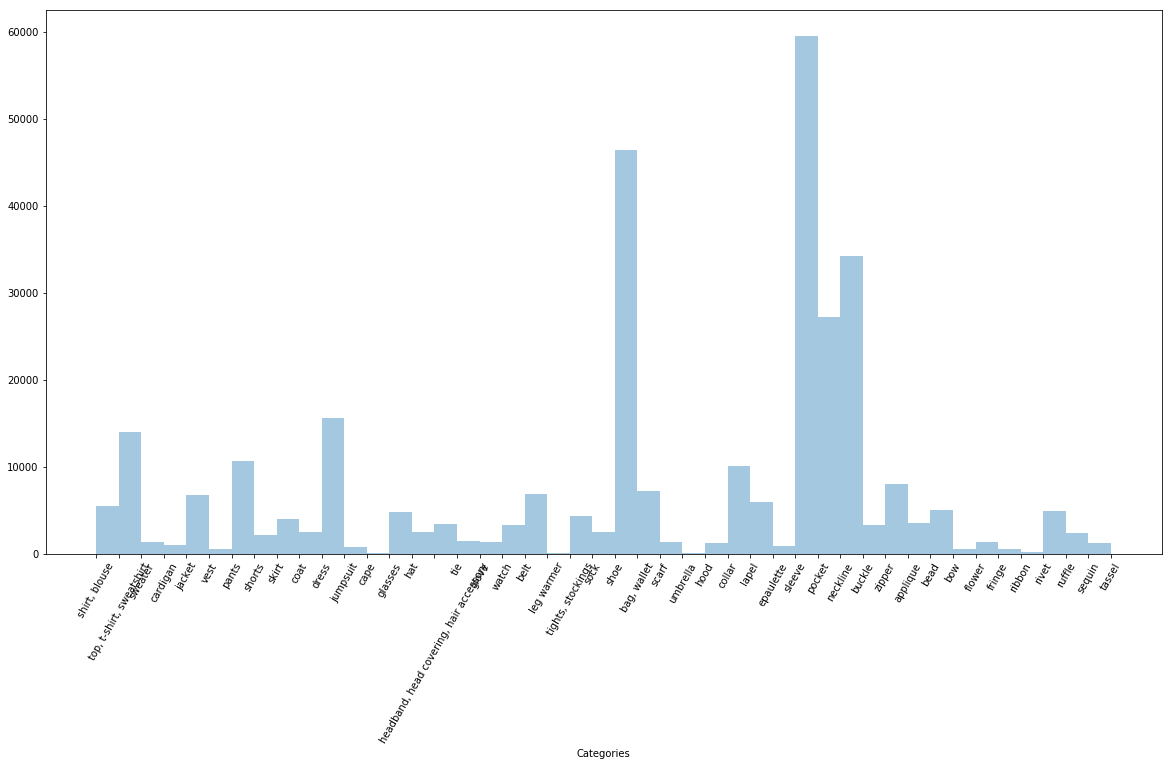

In [104]:
fig, ax = plt.subplots(figsize=(20,10))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xticks([x for x in range(46)])
plt.xticks(rotation=60)
ax.set_xticklabels(id_to_category[x] for x in range(46))
sns.distplot(df['Categories'],bins=45,kde=False)

In [96]:
# df.groupby('Categories').head()

(0, 50000)

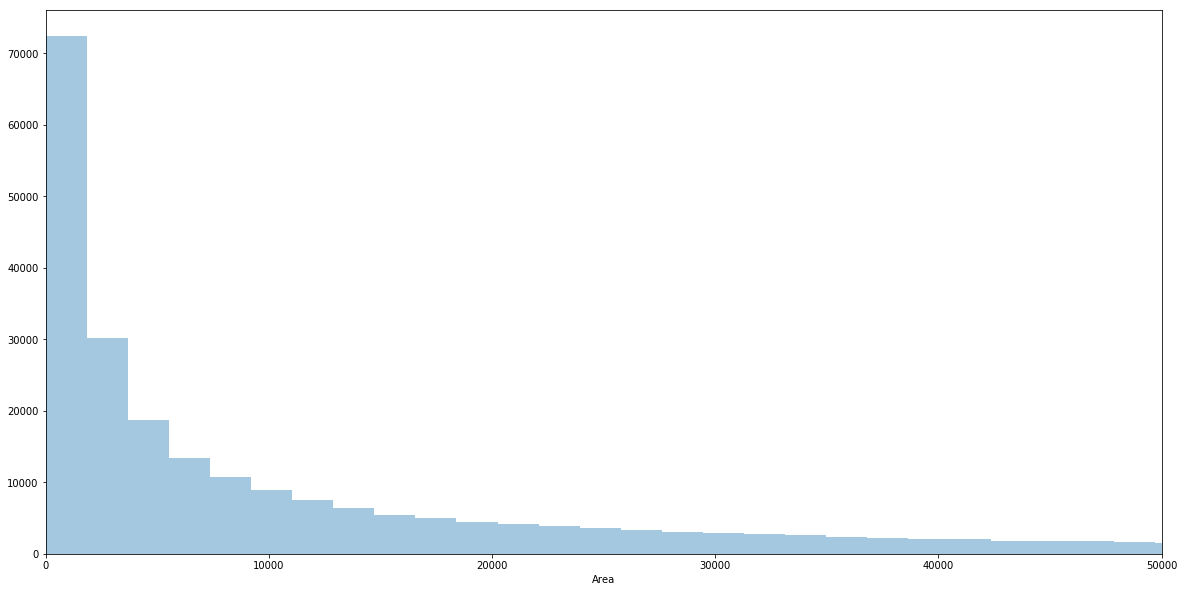

In [111]:
fig, ax = plt.subplots(figsize=(20,10))
sns.distplot(df['Area'], kde=False, bins=10000)
plt.xlim(0, 50000)